In [3]:
###################
# WANDB INTEGRATION
###################


DO_LOGGING = True

if DO_LOGGING:
    import wandb
    wandb.init(project="idao", name="Lgbm early stop 8 folds")


###############
# IMPORT LIBS
###############

import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import os

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

import lightgbm as lgb

from tqdm import tqdm
from pathlib import Path
import joblib
import pickle
import random
import shutil

import matplotlib.pyplot as plt
%matplotlib inline

###############
# SET CONSTANTS
###############

PATH = 'idao2020/'
MODELS_PATH = 'models/'
COLS_TO_DROP = ['target','card_id']

try:
    shutil.rmtree(MODELS_PATH)
    os.mkdir(MODELS_PATH)
except:
    os.mkdir(MODELS_PATH)

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.10.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [4]:
#####################
# SET NOTEBOOK PARAMS
#####################

eval_strategy = 'kfold' # single
MODEL_NAME = 'lgb' # catboost
NSEED = 5
BASE_SEED = 1000
NFOLD = 5

VARIANCE_THRESHOLD = 1
PCA_COMPONENTS = 30
FIXED_SEEDS = [948, 534, 432, 597, 103, 21, 2242, 17, 20, 29]

In [389]:
###############
# DEFINE FUNCS
###############


def roc_auc_score_at_K(predicted_proba, target, rate=0.1): 
    '''
    Competition metric
    '''
    order = np.argsort(-predicted_proba) 
    top_k = int(rate * len(predicted_proba)) 
    return roc_auc_score(target[order][:top_k], predicted_proba[order][:top_k])


def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)

In [390]:
###############
# READ DATA
###############

data = pd.read_csv(PATH + "train.csv")
POSTPROC_THRESH = 0.05

In [392]:
def feature_generation(data):
    
    '''
    Generate new features
    '''
    
    df = data.copy()
    
    def diff_features(df, ft1, ft2):
        df['diff-{}-{}'.format(ft1, ft2)] = df[ft1] - df[ft2]
        return df

    def ratio_features(df, ft2, ft1):
        df['ratio-{}-{}'.format(ft1, ft2)] = df[ft1] / (df[ft2] + 1e-12)
        return df

    def match_features(df, ft1, ft2):
        df['match-{}-{}'.format(ft1, ft2)] = (df[ft1] == df[ft2]).astype(int)
        return df

    def common_regions(df, ft1, ft2):
        missed_regions = []
        used_regions = []
        for reg, count in df[ft1].value_counts().items():
            if count in df[ft2].value_counts().values:
                used_regions.append(reg)
            else:
                missed_regions.append(reg)
        df['common_regions-{}-{}'.format(ft1, ft2)] = df[ft1].apply(lambda x: int(x in used_regions))
        return df
    
    def comb_features(df, ft1, ft2):
        df['comb-{}-{}'.format(ft1, ft2)] = df[ft1].astype(str) + '-' + df[ft2].astype(str)
        return df
    
    
    ##### v01 #####

#     for col in [
#         'addr_region_fact_encoding1',
#         'addr_region_reg_encoding1',
#         'app_addr_region_reg_encoding1',
#         'app_addr_region_fact_encoding1',
#     ]:
#         df[col] = np.round(df[col] * 0.0083, 6).astype(int)
#     df['app_addr_region_sale_encoding1'] = np.round(df['app_addr_region_sale_encoding1'] * 0.0039).astype(int)
#     for col in [
#         'addr_region_fact_encoding2',
#         'addr_region_reg_encoding2',
#         'app_addr_region_reg_encoding2',
#         'app_addr_region_fact_encoding2',
#     ]:
#         df[col] = np.round(df[col] * 1.1).astype(int)
#     df['app_addr_region_sale_encoding2'] = np.round(df['app_addr_region_sale_encoding2'] * 0.007).astype(int)

#     df = diff_features(df, 'sas_limit_after_003_amt', 'sas_limit_last_amt')

#     df = match_features(df, 'sas_limit_after_003_amt', 'sas_limit_last_amt')

#     df = match_features(df, 'addr_region_fact_encoding1', 'addr_region_reg_encoding1')
#     df = match_features(df, 'addr_region_fact_encoding1', 'app_addr_region_reg_encoding1')
#     df = match_features(df, 'addr_region_fact_encoding1', 'app_addr_region_fact_encoding1')
#     df = match_features(df, 'addr_region_reg_encoding1', 'app_addr_region_reg_encoding1')
#     df = match_features(df, 'addr_region_reg_encoding1', 'app_addr_region_fact_encoding1')
#     df = match_features(df, 'app_addr_region_reg_encoding1', 'app_addr_region_fact_encoding1')

#     df = match_features(df, 'addr_region_fact_encoding2', 'addr_region_reg_encoding2')
#     df = match_features(df, 'addr_region_fact_encoding2', 'app_addr_region_reg_encoding2')
#     df = match_features(df, 'addr_region_fact_encoding2', 'app_addr_region_fact_encoding2')
#     df = match_features(df, 'addr_region_reg_encoding2', 'app_addr_region_reg_encoding2')
#     df = match_features(df, 'addr_region_reg_encoding2', 'app_addr_region_fact_encoding2')
#     df = match_features(df, 'app_addr_region_reg_encoding2', 'app_addr_region_fact_encoding2')

#     df = common_regions(df, 'addr_region_fact', 'addr_region_fact_encoding1')
#     df = common_regions(df, 'addr_region_reg', 'addr_region_reg_encoding1')
#     df = common_regions(df, 'app_addr_region_reg', 'app_addr_region_reg_encoding1')
#     df = common_regions(df, 'app_addr_region_fact', 'app_addr_region_fact_encoding1')
#     df = common_regions(df, 'app_addr_region_sale', 'app_addr_region_sale_encoding1')

    ##### v02 #####

#     df = diff_features(df, 'first_loan_date', 'last_loan_date')
#     df = ratio_features(df, 'first_loan_date', 'last_loan_date')
#     df = match_features(df, 'first_loan_date', 'last_loan_date')

#     df = diff_features(df, 'clnt_experience_cur_mnth', 'clnt_experience_total_mnth')

#     df = diff_features(df, 'ttl_inquiries', 'inquiry_1_week')
#     df = diff_features(df, 'inquiry_12_month', 'inquiry_1_week')
#     df = diff_features(df, 'inquiry_9_month', 'inquiry_1_week')
#     df = diff_features(df, 'inquiry_6_month', 'inquiry_1_week')
#     df = diff_features(df, 'inquiry_3_month', 'inquiry_1_week')
#     df = diff_features(df, 'ttl_inquiries', 'inquiry_3_month')
#     df = diff_features(df, 'inquiry_12_month', 'inquiry_3_month')
#     df = diff_features(df, 'inquiry_9_month', 'inquiry_3_month')
#     df = diff_features(df, 'inquiry_6_month', 'inquiry_3_month')
#     df = diff_features(df, 'ttl_inquiries', 'inquiry_6_month')
#     df = diff_features(df, 'inquiry_12_month', 'inquiry_6_month')
#     df = diff_features(df, 'inquiry_9_month', 'inquiry_6_month')
#     df = diff_features(df, 'ttl_inquiries', 'inquiry_9_month')
#     df = diff_features(df, 'inquiry_12_month', 'inquiry_9_month')
#     df = diff_features(df, 'ttl_inquiries', 'inquiry_12_month')

#     df = ratio_features(df, 'ttl_inquiries', 'inquiry_1_week')
#     df = ratio_features(df, 'inquiry_12_month', 'inquiry_1_week')
#     df = ratio_features(df, 'inquiry_9_month', 'inquiry_1_week')
#     df = ratio_features(df, 'inquiry_6_month', 'inquiry_1_week')
#     df = ratio_features(df, 'inquiry_3_month', 'inquiry_1_week')
#     df = ratio_features(df, 'ttl_inquiries', 'inquiry_3_month')
#     df = ratio_features(df, 'inquiry_12_month', 'inquiry_3_month')
#     df = ratio_features(df, 'inquiry_9_month', 'inquiry_3_month')
#     df = ratio_features(df, 'inquiry_6_month', 'inquiry_3_month')
#     df = ratio_features(df, 'ttl_inquiries', 'inquiry_6_month')
#     df = ratio_features(df, 'inquiry_12_month', 'inquiry_6_month')
#     df = ratio_features(df, 'inquiry_9_month', 'inquiry_6_month')
#     df = ratio_features(df, 'ttl_inquiries', 'inquiry_9_month')
#     df = ratio_features(df, 'inquiry_12_month', 'inquiry_9_month')
#     df = ratio_features(df, 'ttl_inquiries', 'inquiry_12_month')
    
#     ##### v03 #####

    df = comb_features(df, 'prt_name', 'channel_name_2')
    df = comb_features(df, 'prt_name', 'clnt_income_month_avg_net_amt') # 132 categories
    df = comb_features(df, 'prt_name', 'clnt_birth_year') # 503 categories
    df = comb_features(df, 'prt_name', 'inquiry_1_week') # 222 categories
    df = comb_features(df, 'prt_name', 'addr_region_fact') # 464 categories
    df = comb_features(df, 'prt_name', 'sas_limit_last_amt') # 142 categories
    df = comb_features(df, 'prt_name', 'clnt_speciality_sphere_name') # 250 categories
    df = comb_features(df, 'prt_name', 'addr_region_fact_encoding1') # 234 categories
    
    
    ########## v04 #############
#     # df['fe_col01'] = df.apply(lambda x: 1 if
#     #          (x['inquiry_1_week'] == x['inquiry_1_month']) & \
#     #          (x['inquiry_1_month'] == x['inquiry_3_month']) & \
#     #          (x['inquiry_3_month'] == x['inquiry_6_month']) & \
#     #          (x['inquiry_6_month'] == x['inquiry_9_month']) & \
#     #          (x['inquiry_9_month'] == x['inquiry_12_month'])
#     #         else 0, axis=1)
#     df['fe_feature_nans'] = sum([df[col].isna() for col in ['feature_10'] + ['feature_{}'.format(x) for x in range(12, 30)]])
#     df['fe_inquiry_mean_diff'] = df['inquiry_1_week'] / 7 + \
#             (df['inquiry_1_month'] - df['inquiry_1_week']) / 23 + \
#             (df['inquiry_3_month'] - df['inquiry_1_month']) / 60 + \
#             (df['inquiry_6_month'] - df['inquiry_3_month']) / 90 + \
#             (df['inquiry_9_month'] - df['inquiry_6_month']) / 90 + \
#             (df['inquiry_12_month'] - df['inquiry_9_month']) / 90
#     df['fe_inquiry_anomaly_day'] = df.apply(lambda x: 1 if
#                                             ((x['inquiry_recent_period'] <= 30) & (x['inquiry_1_month'] == 0)) | \
#                                             ((x['inquiry_recent_period'] <= 89) & (x['inquiry_3_month'] == 0)) | \
#                                             ((x['inquiry_recent_period'] <= 181) & (x['inquiry_6_month'] == 0)) | \
#                                             ((x['inquiry_recent_period'] <= 273) & (x['inquiry_9_month'] == 0)) | \
#                                             ((x['inquiry_recent_period'] <= 273) & (x['inquiry_12_month'] == 0)) | \
#                                             ((x['inquiry_recent_period'] <= 365) & (x['inquiry_12_month'] == 0))
#                                            else 0, axis=1)
#     df['fe_inquiry_mean_before_12_month'] = (df['ttl_inquiries'] - df['inquiry_12_month']) / (df['first_loan_date'] + 366)

#     df = diff_features(df, 'loans_main_borrower', 'loans_active')
#     df = match_features(df, 'addr_region_reg', 'addr_region_fact')

#     df = diff_features(df, 'inquiry_1_month', 'inquiry_1_week')
#     df = diff_features(df, 'inquiry_3_month', 'inquiry_1_month')
#     df = diff_features(df, 'inquiry_6_month', 'inquiry_3_month')
#     df = diff_features(df, 'inquiry_9_month', 'inquiry_6_month')
#     df = diff_features(df, 'inquiry_12_month', 'inquiry_9_month')
#     df = diff_features(df, 'ttl_inquiries', 'inquiry_12_month')

#     df['inquiry_1_week*sas_limit_last_amt'] = df['inquiry_1_week']*df['sas_limit_last_amt']
#     df['inquiry_1_month*sas_limit_last_amt'] = df['inquiry_1_month']*df['sas_limit_last_amt']
#     df['inquiry_recent_period*sas_limit_last_amt'] = df['inquiry_recent_period']*df['sas_limit_last_amt']

    return df

In [393]:
#################
# PREPROCESS DATA
#################


def add_pca(data):
    '''
    Add pca features to data
    '''
    
    pca = PCA(n_components=PCA_COMPONENTS, random_state=BASE_SEED)
    pcas = pca.fit_transform(data.iloc[:, 2:])
    pcas = pd.DataFrame(pcas, columns=[f'pca_{i}' for i in range(PCA_COMPONENTS)])
    data_all = pd.concat([data, pcas], axis=1)
    
    
    # save pca for inference
    joblib.dump(pca, MODELS_PATH + f'pca.pkl')
    
    return data_all

def variance_threshold(data):
    '''
    Filter data based on variance threshold
    '''
    cols_numeric = []
    for col in data.columns[2:]:
        if data[col].dtype != 'object':
                cols_numeric.append(col)
                
    mask = (data[cols_numeric].var() < VARIANCE_THRESHOLD).values
    data.drop(columns = np.array(cols_numeric)[mask], inplace = True)
    
    return data

def preprocess_data(data):
    '''
    Fill nans and label encode
    '''
    for i, col in enumerate(data.columns[2:]):
        if data[col].dtype == 'object':
            le = LabelEncoder()
            data[col] = le.fit_transform(data[col])
            joblib.dump(le, MODELS_PATH + f'le_{col}.pkl')
            
            
    return data

data = feature_generation(data)
data = preprocess_data(data)
# data = variance_threshold(data)
# data = add_pca(data)

In [395]:
def running_train(X_train, Y_train, X_val, Y_val, i_fold=None, seed=None, params = None):
    # prepare for train
    
    params = {
              "objective": "cross_entropy_lambda",
                "boosting": "gbdt",
                "n_estimators": 3000,
                "num_leaves": 60,
                "num_threads": 8,
              "random_state": seed,
              }
    
    
    model = lgb.LGBMClassifier(**params) # define model here
    
    # Fit and save model
    model.fit(X_train, Y_train,   eval_set=(X_val, Y_val), early_stopping_rounds=500, verbose=False)
    joblib.dump(model, MODELS_PATH + f'{MODEL_NAME}_{i_fold}_{seed}.pkl')

In [396]:
# kfold
def train_kfold_model(train_df):
    X_train_val = train_df.drop(columns = COLS_TO_DROP)
    Y_train_val = train_df['target']

    oof = np.zeros((X_train_val.shape[0], NSEED)) # cv_score
    seeds = []
    for i_seed in range(NSEED):
        #seed = random.randint(0, BASE_SEED)
        seed = FIXED_SEEDS[i_seed]
        seed_everything(seed)
        
        seeds.append(seed)
        print('Seed: {}, {}/{}'.format(seed, i_seed + 1, NSEED))
        kf = KFold(n_splits=NFOLD, random_state=seed, shuffle=True)
        for i_fold, (train_idx, val_idx) in enumerate(kf.split(X_train_val, Y_train_val)):
            print("# Fold: {}/{} (seed: {}/{})".format(i_fold + 1, NFOLD, i_seed + 1, NSEED))

            # dataset
            X_train, Y_train = X_train_val.iloc[train_idx], Y_train_val[train_idx]
            X_val, Y_val = X_train_val.iloc[val_idx], Y_train_val[val_idx]
                

            # train
            running_train(X_train, Y_train, X_val, Y_val, i_fold=i_fold, seed=seed)

            # predict on oof
            print('predict on oof...', end='')
            model = joblib.load(MODELS_PATH + f'{MODEL_NAME}_{i_fold}_{seed}.pkl')
            
            prediction = model.predict_proba(X_val)[:, 1]
    
            oof[val_idx, i_seed] = prediction
            print('  done.')
    
    oof = np.mean(oof, axis = 1)
    cv_rocauc = roc_auc_score(Y_train_val, oof)
    oof = postprocess_predictions(oof)
    cv_score = roc_auc_score_at_K(oof, Y_train_val)
    
    print('{} folds ROC AUC top 10: {:.5f} ROC AUC {:.5f}'.format(NFOLD, cv_score, cv_rocauc))
    if DO_LOGGING:
        wandb.summary['rocauc_10']= cv_score
        wandb.summary['rocauc_all']= cv_rocauc
    
    return seeds, oof

In [397]:
# single model
def train_single_model(train_df):
    # obtain train, val, test
    train_df, val_df = train_test_split(train_df, test_size=0.2, shuffle=True, random_state=BASE_SEED)

    X_train, X_val, Y_train, Y_val = train_df.drop(columns = COLS_TO_DROP), val_df.drop(columns = COLS_TO_DROP),\
    train_df['target'], val_df['target']
    
    
    # train
    running_train(X_train, Y_train, X_val, Y_val, 0, 0)

    # predict on test
    print('predict on valid...', end='')
    model = joblib.load(MODELS_PATH + f'{MODEL_NAME}_{0}_{0}.pkl')
    predictions = model.predict_proba(X_val)[:, 1]
    print('  done.\n')
    
    cv_rocauc = roc_auc_score(Y_val, predictions)
    predictions = postprocess_predictions(predictions)
    cv_score = roc_auc_score_at_K(predictions, Y_val.values)
    
    print('ROC AUC top 10: {:.5f} ROC AUC {:.5f}'.format(cv_score, cv_rocauc))
    if DO_LOGGING:
        wandb.summary['rocauc_10']= cv_score
        wandb.summary['rocauc_all']= cv_rocauc
    
    return predictions, Y_val
    

In [398]:
def postprocess_predictions(predictions, rate = 0.1):
    thresh = POSTPROC_THRESH
    order = np.argsort(-predictions)  # -> 5%: лучшие (единицы) | 90% занулили (все что между) | 5% оставили (нули)
    top_k = int(0.1 * len(predictions))
    
    predictions[order[int(thresh * len(predictions)):int((1 - rate + thresh) * len(predictions))]] = -1
    
    return predictions

In [399]:
if eval_strategy == 'kfold':
    seeds, predictions = train_kfold_model(data)
elif eval_strategy == 'single':
    predictions, y_val = train_single_model(data)
else:
    print('eval_strategy should be \"kfold\" or \"single\"')

Seed: 948, 1/5
# Fold: 1/5 (seed: 1/5)
predict on oof...  done.
# Fold: 2/5 (seed: 1/5)
predict on oof...  done.
# Fold: 3/5 (seed: 1/5)
predict on oof...  done.
# Fold: 4/5 (seed: 1/5)
predict on oof...  done.
# Fold: 5/5 (seed: 1/5)
predict on oof...  done.
Seed: 534, 2/5
# Fold: 1/5 (seed: 2/5)
predict on oof...  done.
# Fold: 2/5 (seed: 2/5)
predict on oof...  done.
# Fold: 3/5 (seed: 2/5)
predict on oof...  done.
# Fold: 4/5 (seed: 2/5)
predict on oof...  done.
# Fold: 5/5 (seed: 2/5)
predict on oof...  done.
Seed: 432, 3/5
# Fold: 1/5 (seed: 3/5)
predict on oof...  done.
# Fold: 2/5 (seed: 3/5)
predict on oof...  done.
# Fold: 3/5 (seed: 3/5)
predict on oof...  done.
# Fold: 4/5 (seed: 3/5)
predict on oof...  done.
# Fold: 5/5 (seed: 3/5)
predict on oof...  done.
Seed: 597, 4/5
# Fold: 1/5 (seed: 4/5)
predict on oof...  done.
# Fold: 2/5 (seed: 4/5)
predict on oof...  done.
# Fold: 3/5 (seed: 4/5)
predict on oof...  done.
# Fold: 4/5 (seed: 4/5)
predict on oof...  done.
# Fold: 5

ERROR:wandb.jupyter:Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


predict on oof...  done.
5 folds ROC AUC top 10: 0.91032 ROC AUC 0.74480


wandb: Wandb version 0.10.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


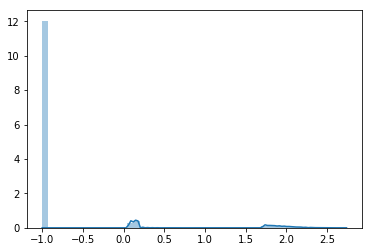

In [147]:
import seaborn as sns
sns.distplot(predictions)

In [335]:
wandb.summary['rocauc_10']= 0.91248
wandb.summary['rocauc_all']= 0.74580

ERROR:wandb.jupyter:Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.10.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [336]:
if DO_LOGGING:
    wandb.summary['lb_score'] =89.78

ERROR:wandb.jupyter:Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.10.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [5]:
#################
# FEAT IMPORTANCE
#################


if eval_strategy == 'single':
    model = joblib.load(MODELS_PATH + f'{MODEL_NAME}_{0}_{0}.pkl')
    lgb.plot_importance(model, max_num_features = 15)

    importances = pd.DataFrame(sorted(zip(model.feature_importances_,data.columns[2:])), columns=['Value','Feature'])
    importances.to_csv('importances.csv', index = None)